<a href="https://colab.research.google.com/github/abhisheksara2001/Face-Expression-classifier/blob/main/faceExp_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction**
the dataset comes from https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset.
<br>
the dataset consist of 48X48 grey scale images of face. Each face is labeled one of the 7 facial expression (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral)
<hr>
let's download the dataset zipfile from kaggle.

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# change permission
!chmod 600 ~/.kaggle/kaggle.json

# kaggle API command
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 91% 110M/121M [00:01<00:00, 45.6MB/s] 
100% 121M/121M [00:01<00:00, 69.5MB/s]


Extract the dataset file from zipfile.

In [3]:
from zipfile import ZipFile
file_name = 'face-expression-recognition-dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

##Data Visualization
showing images from all the expressions.

In [4]:
# importing some liberies

from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

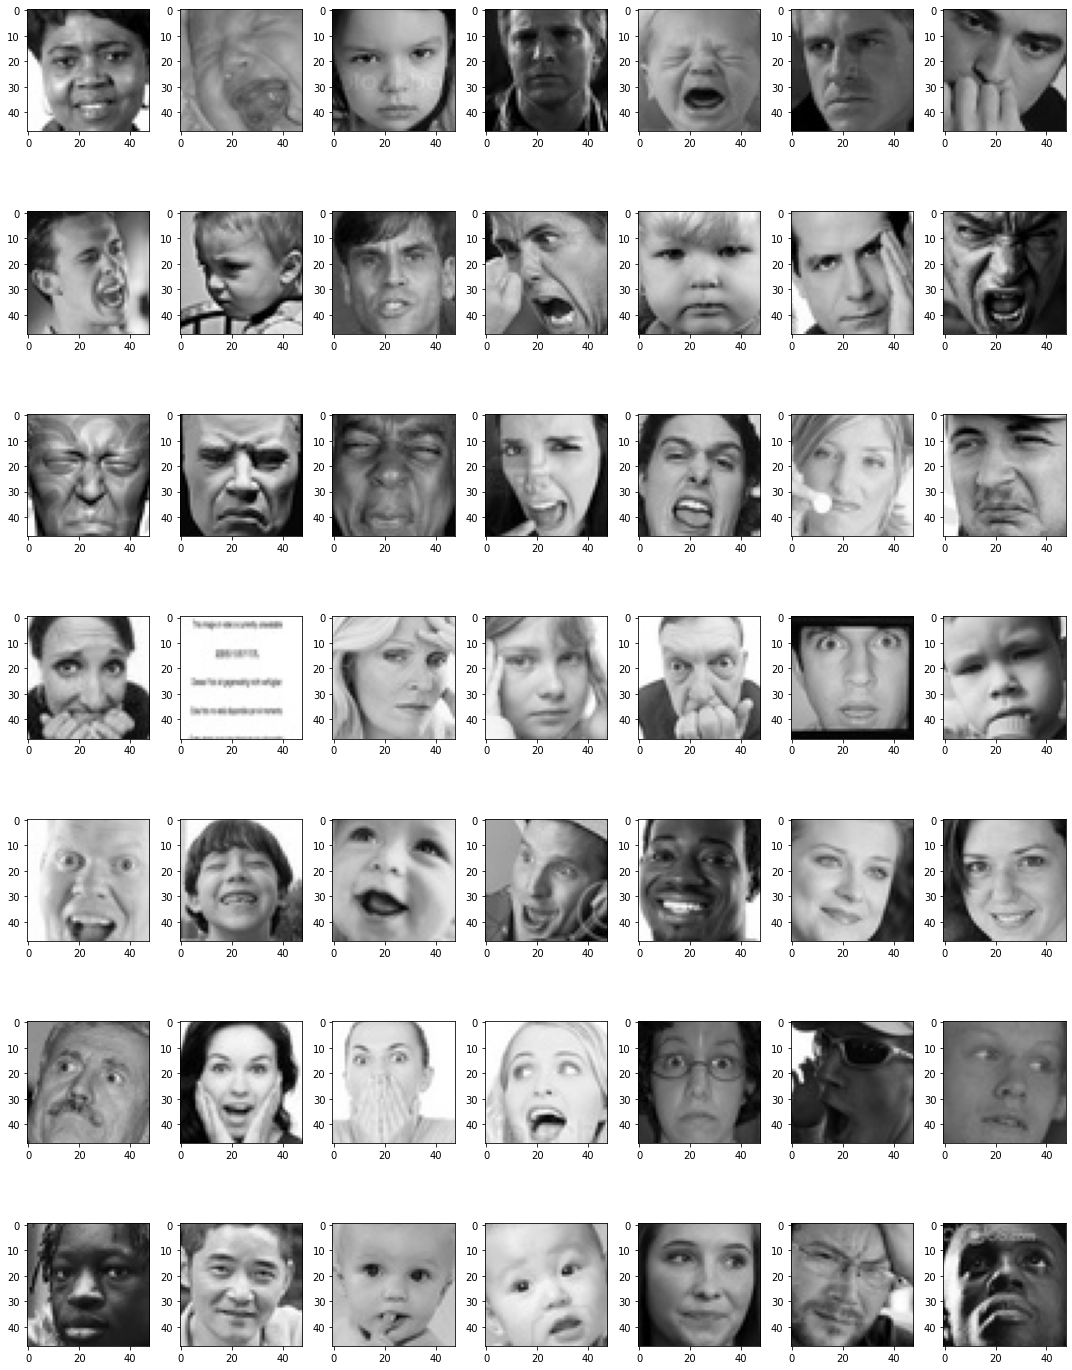

In [5]:
base_path = "/content/images/images/"

plt.figure(0, figsize=(15,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
  for i in range(7):
    cpt = cpt + 1
    plt.subplot(7,7,cpt)
    img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
    plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [6]:
for expression in os.listdir(base_path + "train"):
  print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

4938 sad images
3993 angry images
436 disgust images
4103 fear images
7164 happy images
3205 surprise images
4982 neutral images


#Data Generator
We are using ImageDataGenerator method from Keras.Preprocessing, this method allow us to take images directly from directory and allow us to do modify images on fly without saving them first. We can also choose image size and batch sizes in this method.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


#CNN Model
we chose to use Convolutional Neural Network for Image classification Problem, this type neural network are good when we need to extract features from the images and is widely used in image related problem statements.
<br>

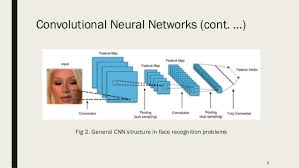

In [8]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# designing model
model = Sequential()

# Conv 1 layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Conv 2 layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Conv 3 layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Conv 4 layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# FC 1 layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# FC 2 layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

My model have 4 Convolutional layers and 2 Fully Connected layers.

In [10]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
225/225 [==============================] - 12s 53ms/step - loss: 1.7369 - accuracy: 0.3339 - val_loss: 1.7260 - val_accuracy: 0.3402
Epoch 2/50
225/225 [==============================] - 12s 52ms/step - loss: 1.6675 - accuracy: 0.3622 - val_loss: 1.5984 - val_accuracy: 0.3868
Epoch 3/50
225/225 [==============================] - 12s 52ms/step - loss: 1.5966 - accuracy: 0.3864 - val_loss: 1.5772 - val_accuracy: 0.3991
Epoch 4/50
225/225 [==============================] - 12s 52ms/step - loss: 1.5407 - accuracy: 0.4096 - val_loss: 1.5321 - val_accuracy: 0.4239
Epoch 5/50
225/225 [==============================] - 12s 53ms/step - loss: 1.5020 - accuracy: 0.4233 - val_loss: 1.4397 - val_accuracy: 0.4472
Epoch 6/50
225/225 [==============================] - 12s 53ms/step - loss: 1.4525 - accuracy: 0.4439 - val_loss: 1.4741 - val_accuracy: 0.4411
Epoch 7/50
225/225 [==============================] - 12s 53ms/step - loss: 1.4108 - accuracy: 0.4573 - val_loss: 1.4254 - val_accuracy:

In [11]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

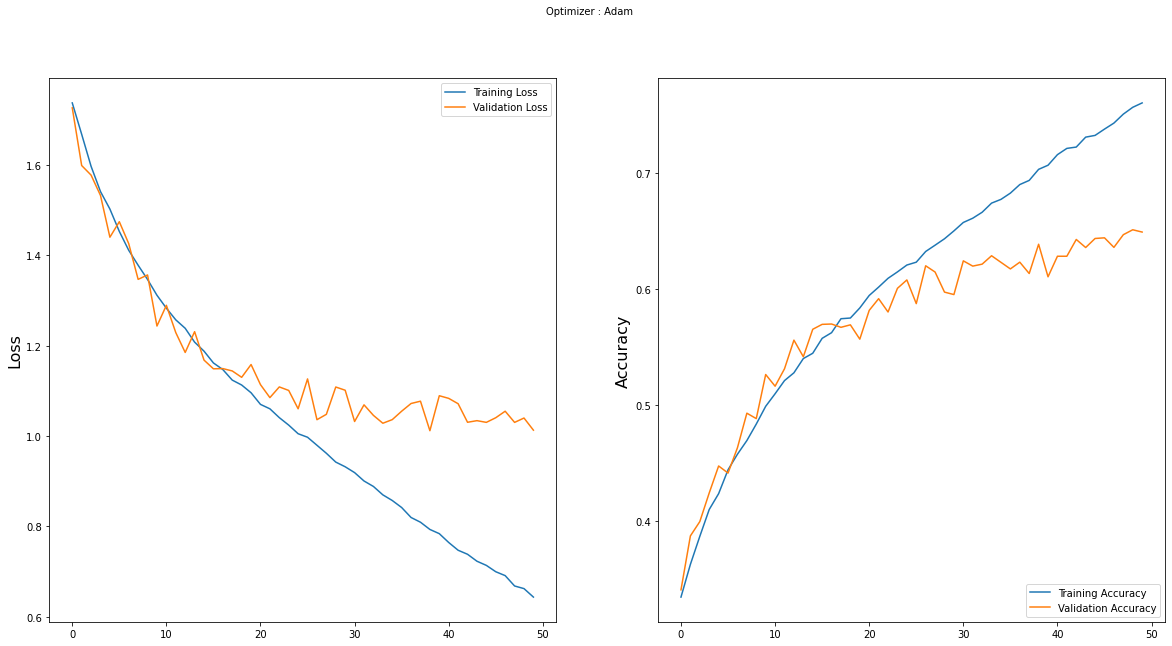

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

<Figure size 432x288 with 0 Axes>

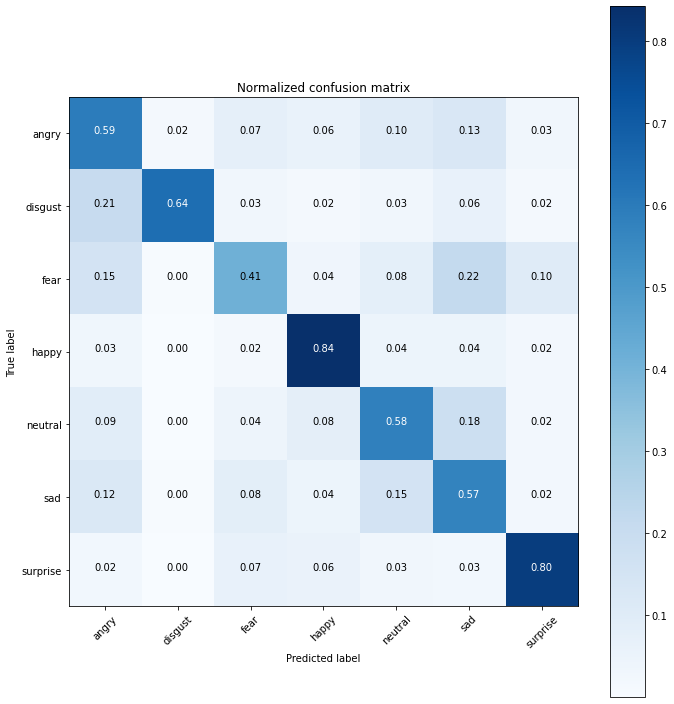

In [17]:
import numpy as np

predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()